In [1]:
import torch
import sys
sys.path.append('../')
from utils import save_gif, make_grid_from_temporal_batch, normalize, save_video, spherical_interpolation, plot_images
from denoiser import DDIM
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms.functional as tvf
import numpy as np

from PIL import Image
from torchvision.utils import make_grid, save_image
from data_manager.get_dataset import get_dataset
from torch.utils.data import DataLoader
from glob import glob

from IPython.display import Image as IPythonImage
import IPython.display as display
import ipyplot
import ipywidgets as widgets

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

log_name = "Celeb256"
ddim = DDIM.load_from_training_log(f"../../logs/training/{log_name}", model_name="ema_model.pt", device=device)
ddim.eval()
ddim.to(device);

Loading model...
Finished testing UNet
Creating instance of class...
Denoiser initialized


In [3]:
masks = {"mouth256": (95, 178, 160, 205), "sunglasses256": (65, 105, 190, 140), "hair256": (70, 50, 256-70, 256)}
# haircolor: 50, 40, 256-50, 256

# Changing intensity values of latents

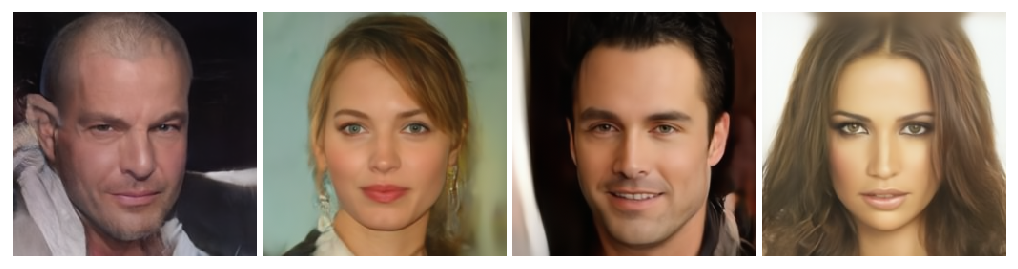

In [6]:
n = 4
latents = torch.randn(n, *ddim.data_shape).to(device)
ddim.eta = 0
ddim.model.eval()
sample = ddim.sample(device, timesteps=20, latents=latents)
plot_images((sample+1)/2, clip=True, scale=3, nrow=-1, pad_value=1, padding=6)

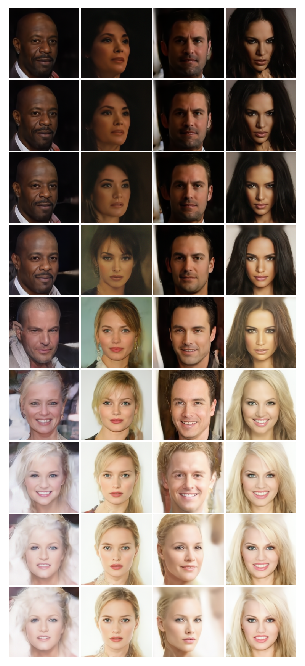

In [7]:
num_interp = 9
interp = torch.linspace(-0.02, 0.02, num_interp)
new_latents = torch.cat([latents.clone() + i for i in interp], dim=0)
x = ddim.sample(device, timesteps=20, latents=new_latents)
plot_images((x+1)/2, clip=True, scale=3, nrow=n, pad_value=1, padding=6)

In [28]:
basefolder = f"../../outputs/latent_manipulation/intensity_modification/full"
newx = x.view(num_interp, n, *ddim.data_shape)
for i in range(len(newx)):
    e = F.avg_pool2d(newx[i], 2, 2)
#     plot_images((e+1)/2, clip=True)

    save_image(((e+1)/2).clip(0, 1), f"{basefolder}/im_{i}.png", nrow=1,padding=0)
    

In [599]:
basefolder = f"../../outputs/latent_manipulation/intensity_modification/full_extras"
newx = x.view(num_interp, n, *ddim.data_shape)

# newx = F.avg_pool2d(x, 3, 3)
# print(x.shape)
# data = []
# for i in range(num_interp):
#     data.append(x[i::n])
# plot_images((newx[0]+1)/2, clip=True, scale=3)
for i in range(len(newx)):
    e = F.avg_pool2d(newx[i], 4, 4)
#     plot_images((e+1)/2, clip=True)

    save_image(((e+1)/2).clip(0, 1), f"{basefolder}/im_{i}.png", nrow=n,padding=0)
# save_image(((newx+1)/2).clip(0, 1), f"{basefolder}/im.png", nrow=num_interp,padding=0)

## Each color channel

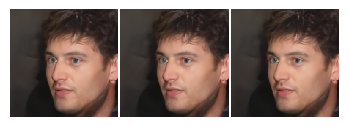

In [8]:
n = 3
latents = torch.randn(1, *ddim.data_shape).to(device).repeat(n, *[1]*n)
ddim.eta = 0
ddim.model.eval()
sample = ddim.sample(device, timesteps=20, latents=latents)
plot_images((sample+1)/2, clip=True, scale=1, nrow=-1, pad_value=1, padding=6)

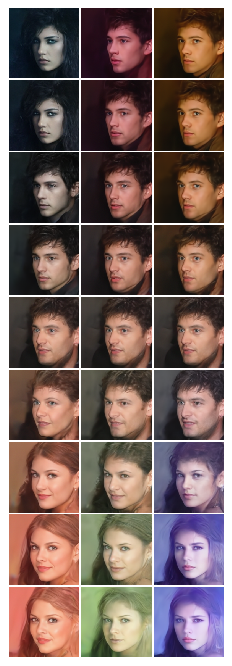

In [9]:
num_interp = 9
interp = torch.linspace(-0.02, 0.02, num_interp)
new_latents = torch.cat([latents.clone() + torch.eye(3)[..., None, None].to(device) * i for i in interp], dim=0)
# plot_images((new_latents+1)/2, clip=True, scale=3, nrow=n, pad_value=1, padding=6)
x = ddim.sample(device, timesteps=20, latents=new_latents)
plot_images((x+1)/2, clip=True, scale=3, nrow=3, pad_value=1, padding=6)

In [57]:
basefolder = f"../../outputs/latent_manipulation/intensity_modification/color"
newx = x.view(num_interp, n, *ddim.data_shape)
for i in range(len(newx)):
    e = F.avg_pool2d(newx[i], 2, 2)
#     plot_images((e+1)/2, clip=True)

    save_image(((e+1)/2).clip(0, 1), f"{basefolder}/im_{i}.png", nrow=1,padding=0)

# Partial latent manipulation

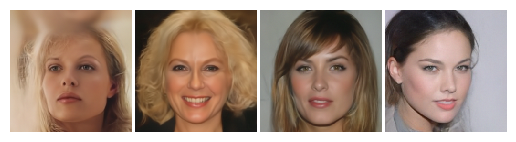

In [13]:
n = 4
latents = torch.randn(n, *ddim.data_shape).to(device)
samples = ddim.sample(device, timesteps=20, latents=latents)
plot_images((samples+1)/2, clip=True, scale=1.5, nrow=-1, pad_value=1, padding=6)


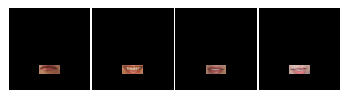

In [14]:
mask_x1, mask_y1, mask_x2, mask_y2 = masks["mouth256"]
mask = torch.zeros(*ddim.data_shape).to(device)
mask[..., mask_y1:mask_y2, mask_x1:mask_x2] = 1
# mask = 1 - mask
plot_images((samples+1)/2 * mask, clip=True, scale=1, nrow=-1, pad_value=1, padding=6)
# torch.save(latents[-1][None, ...], f"../../outputs/latent_manipulation/intensity_modification/latents/smile3.pt")

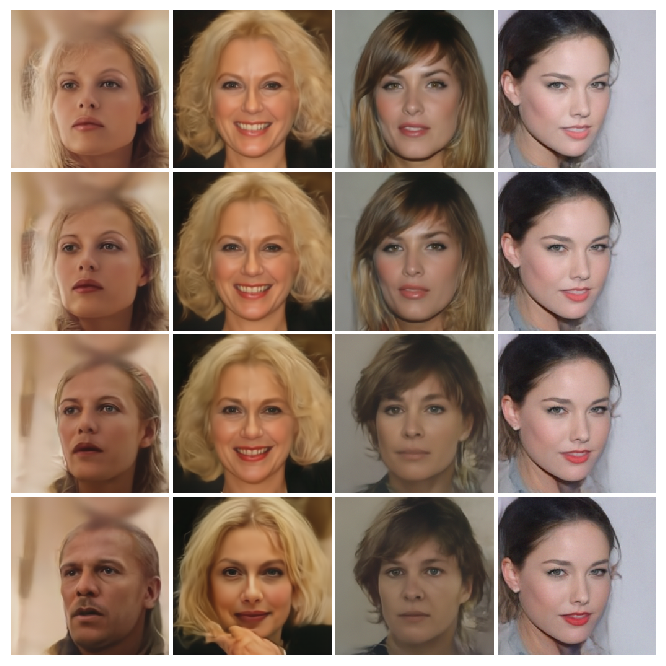

In [15]:
new_latents = torch.cat([latents.clone() + i*mask for i in torch.linspace(0,-0.04, 4)], dim=0)
# print(.shape)
# new_latents = torch.cat([latents.clone() + torch.stack([mask[0]*i, mask[0]*0, mask[0]*0], dim=0) for i in torch.linspace(0,0.1, 4)], dim=0)
# plot_images((new_latents+1)/2, clip=True, scale=3, nrow=n, pad_value=1, padding=6)
x = ddim.sample(device, timesteps=20, latents=new_latents)
plot_images((x+1)/2, clip=True, scale=3, nrow=latents.shape[0], pad_value=1, padding=6)

In [73]:
latent_options = sorted(glob("../../outputs/latent_manipulation/intensity_modification/latents/*"))
selection = widgets.SelectMultiple(
    options=[o.split("/")[-1] for o in latent_options],
    value=[],
    rows=10,
    description='Latents',
    disabled=False
)
selection

SelectMultiple(description='Latents', options=('dark_skinned_man.pt', 'hair_to_hat.pt', 'haircolor1.pt', 'hair…

In [74]:
base = "../../outputs/latent_manipulation/intensity_modification/latents"
latents = torch.cat([torch.load(f"{base}/{name}").to(device) for name in selection.value], dim=0)
print(latents.shape)

torch.Size([1, 3, 256, 256])


In [ ]:
latents = torch.randn(1, *ddim.data_shape).to(device)

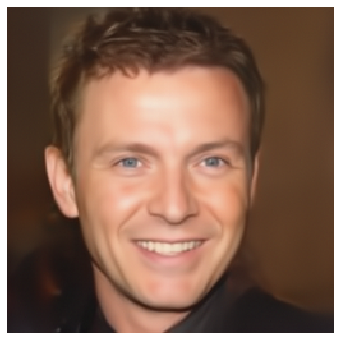

In [75]:
samples = ddim.sample(device, timesteps=20, latents=latents)
plot_images((samples+1)/2, clip=True, scale=1.5, nrow=-1, pad_value=1, padding=6)

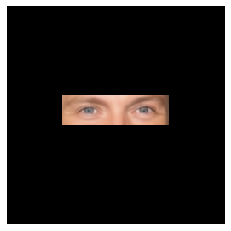

In [76]:
# mask_x1, mask_y1, mask_x2, mask_y2 = 10, 80, 180, 210
maskname = "sunglasses256"
mask_x1, mask_y1, mask_x2, mask_y2 = masks[maskname]
mask = torch.zeros(*ddim.data_shape).to(device)    
mask[..., mask_y1:mask_y2, mask_x1:mask_x2] = 1
if maskname == "hair256":
    mask = 1 - mask
plot_images((samples+1)/2 * mask, clip=True, scale=1, nrow=-1, pad_value=1, padding=6)

[ 0.         -0.01166667 -0.02333333 -0.035     ]


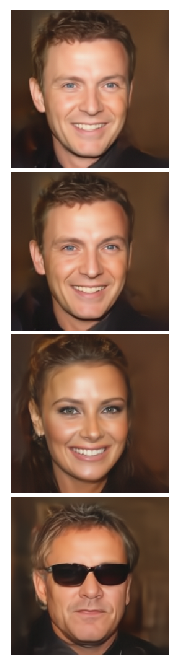

In [81]:
num_interps = 4
start, end = 0, -0.035
values = torch.linspace(start, end, num_interps).numpy()
print(values)
new_latents = torch.cat([latents.clone() + i*mask for i in values], dim=0)
# torch.save(new_latents[-2][None, ...], f"../../outputs/latent_manipulation/intensity_modification/latents/smile_finished2.pt")
# plot_images((new_latents+1)/2, clip=True, scale=3, nrow=n, pad_value=1, padding=6)
x = ddim.sample(device, timesteps=20, latents=new_latents)
plot_images((x+1)/2, clip=True, scale=3, nrow=latents.shape[0], pad_value=1, padding=6)

In [61]:
basefolder = f"../../outputs/latent_manipulation/intensity_modification/partial/mouth_brighter"
newx = x.view(num_interps, latents.shape[0], *ddim.data_shape)
factor = 2
for i in range(len(newx)):
    e = F.avg_pool2d(newx[i], factor, factor)
#     plot_images((e+1)/2, clip=True)

    save_image(((e+1)/2).clip(0, 1), f"{basefolder}/im_{i}.png", nrow=1,padding=0)
torch.save(torch.randn(0,), f"{basefolder}/start_{start}_end_{end}_mask_{masks[maskname]}_maskdivided_{[m//factor for m in masks[maskname]]}")
# torch.save(torch.randn(0,), f"{basefolder}/")

FileNotFoundError: [Errno 2] No such file or directory: '../../outputs/latent_manipulation/intensity_modification/partial/mouth_brighter/im_0.png'

# Feature transfer through latent transfer

In [ ]:
latents = torch.randn(2, *ddim.data_shape).to(device)

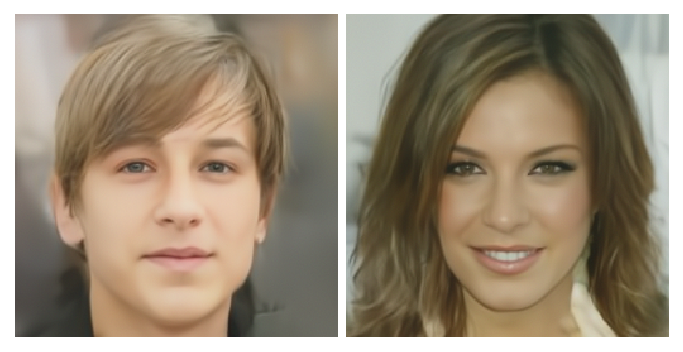

In [ ]:
ddim.eta = 0
ddim.model.eval()
sample = ddim.sample(device, timesteps=20, latents=latents)
plot_images((sample+1)/2, clip=True, scale=2, nrow=-1, pad_value=1, padding=6)

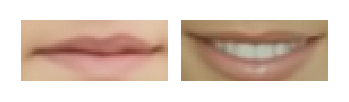

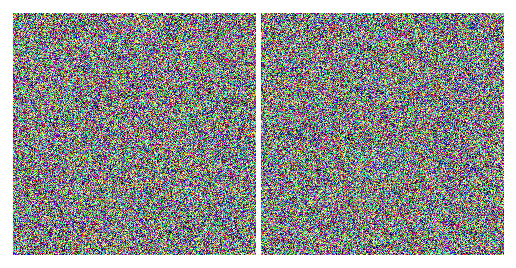

In [ ]:

mask_x1, mask_y1, mask_x2, mask_y2 = masks["mouth256"]


plot_images((sample[..., mask_y1:mask_y2, mask_x1:mask_x2]+1)/2, clip=True, scale=1, nrow=-1, pad_value=1, padding=6)
new_latents = latents.clone()
new_latents[..., mask_y1:mask_y2, mask_x1:mask_x2] = latents[-1][None, :, mask_y1:mask_y2, mask_x1:mask_x2].repeat_interleave(latents.shape[0], dim=0)
plot_images((new_latents+1)/2, clip=True, scale=1.5, nrow=-1, pad_value=1, padding=6)

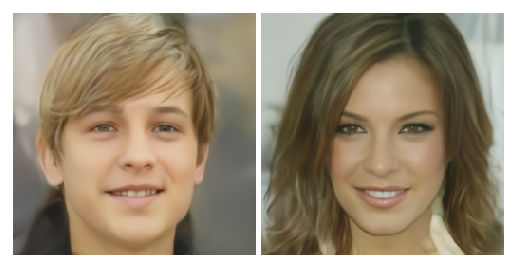

In [ ]:
x = ddim.sample(device, timesteps=20, latents=new_latents.clone())
plot_images((x+1)/2, clip=True, scale=1.5, nrow=-1, pad_value=1, padding=6)

In [ ]:
basefolder = "../../outputs/latent_manipulation/copy_paste/sunglasses2"
for i in range(len(x)):
    scale = 2
    e1 = F.avg_pool2d(sample[i], scale, scale)
    e2 = F.avg_pool2d(x[i], scale, scale)
    e3 = latents[i][:, ::scale, ::scale]
    e4 = new_latents[i][:, ::scale, ::scale]
    save_image(((e1+1)/2).clip(0, 1), f"{basefolder}/orig_{i}.png")
    save_image(((e2+1)/2).clip(0, 1), f"{basefolder}/manip_{i}.png")
    save_image(((e3+1)/2).clip(0, 1), f"{basefolder}/latent_orig_{i}.png")
    save_image(((e4+1)/2).clip(0, 1), f"{basefolder}/latent_manip_{i}.png")

#     plot_images((e3+1)/2, clip=True)
#     edge_x1, edge_y1, edge_x2, edge_y2
    edges = ((mask_x1-scale)//scale, (mask_y1-scale)//scale, (mask_x2+scale)//scale, (mask_y2+scale)//scale)
    save_image(torch.randn(3, 1, 1), f"{basefolder}/{edges}.png")
    print(edges)
#     plot_images((e1_edged+1)/2, clip=True)
    

(31, 51, 96, 76)
(31, 51, 96, 76)
